In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


In [31]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/CTGAN/Dataset/train_category.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/CTGAN/Dataset/test_category.csv"
test_data = pd.read_csv(test_data_path)

In [32]:
keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']

data_classification = data.copy()
test_classification = test_data.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)

In [19]:
data_classification.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [28]:
data['term_months'].unique()

array([36, 60], dtype=int64)

In [29]:
test_data['term_months'].unique()

array([36, 60], dtype=int64)

## Base
### Categorical feature Preprocessing
- LabelEncoding
    - term_months
    - sub_grade
- One-hot-Encoding
    - debt_settlement_flag
    - home_ownership
    - purpose

In [33]:
Labelencoding_features = ['term_months', 'sub_grade']
onehot_features = ['debt_settlement_flag', 'home_ownership', 'purpose']

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

label_encoders = {}
for col in Labelencoding_features:
    le = LabelEncoder()
    data_classification[col] = le.fit_transform(data_classification[col])
    label_encoders[col] = le

# One-Hot Encoding
onehot_encoded = onehot_encoder.fit_transform(data_classification[onehot_features])
onehot_encoded_df = pd.DataFrame(
    onehot_encoded, 
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=data_classification.index
)

# Merge
data_classification.drop(columns=onehot_features, inplace=True)
data_classification = pd.concat([data_classification, onehot_encoded_df], axis=1)

print("✅ Encoding 완료! 결과 shape:", data_classification.shape)

✅ Encoding 완료! 결과 shape: (1116458, 35)


In [34]:
for col in Labelencoding_features:
    le = label_encoders[col]
    test_classification[col] = le.transform(test_classification[col])

# One-Hot Encoding (train에서 fit된 onehot_encoder 재사용)
onehot_encoded_test = onehot_encoder.transform(test_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=test_classification.index
)

# Merge
test_classification.drop(columns=onehot_features, inplace=True)
test_classification = pd.concat([test_classification, onehot_encoded_test_df], axis=1)

print("✅ 테스트 데이터 인코딩 완료! 결과 shape:", test_classification.shape)

✅ 테스트 데이터 인코딩 완료! 결과 shape: (744306, 35)


In [36]:
test_classification.head()

,last_fico_range_high,annual_inc,dti,mo_sin_old_rev_tl_op,revol_util,int_rate,installment,avg_cur_bal,revol_bal,sub_grade,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,739.0,8000.0,122.52,437.0,0.180,0.2485,634.89,30180.0,4184.0,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,499.0,68000.0,22.04,149.0,0.115,0.0917,392.12,2861.0,3454.0,6,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,789.0,52000.0,19.78,134.0,0.380,0.0917,382.55,8456.0,7670.0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,544.0,35000.0,12.04,52.0,0.303,0.1646,247.70,1234.0,6270.0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,689.0,48500.0,15.96,72.0,0.177,0.1502,41.62,17131.0,3542.0,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_test = test_classification.drop(columns = "loan_status")
y_test = test_classification[['loan_status']]

In [43]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.13, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 971318 samples (87.0%)
Validation size: 145140 samples (13.0%)
Test size: 744306 samples (66.7%)


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=500,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.49145	validation_1-logloss:0.49146
[1]	validation_0-logloss:0.48638	validation_1-logloss:0.48639
[2]	validation_0-logloss:0.48145	validation_1-logloss:0.48147
[3]	validation_0-logloss:0.47667	validation_1-logloss:0.47668
[4]	validation_0-logloss:0.47201	validation_1-logloss:0.47203
[5]	validation_0-logloss:0.46748	validation_1-logloss:0.46750
[6]	validation_0-logloss:0.46307	validation_1-logloss:0.46309
[7]	validation_0-logloss:0.45877	validation_1-logloss:0.45880
[8]	validation_0-logloss:0.45458	validation_1-logloss:0.45461
[9]	validation_0-logloss:0.45049	validation_1-logloss:0.45053
[10]	validation_0-logloss:0.44650	validation_1-logloss:0.44655
[11]	validation_0-logloss:0.44261	validation_1-logloss:0.44267
[12]	validation_0-logloss:0.43881	validation_1-logloss:0.43887
[13]	validation_0-logloss:0.43510	validation_1-logloss:0.43517
[14]	validation_0-logloss:0.43147	validation_1-logloss:0.43154
[15]	validation_0-logloss:0.42793	validation_1-logloss:0.42800
[1

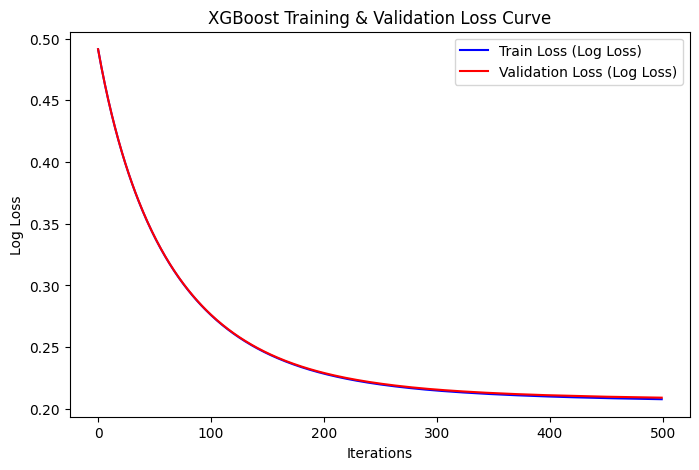

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94    599114
           1       0.78      0.76      0.77    145192

    accuracy                           0.91    744306
   macro avg       0.86      0.86      0.86    744306
weighted avg       0.91      0.91      0.91    744306



In [45]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [46]:
from sklearn.metrics import confusion_matrix
# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 행: 실제값 (y_test), 열: 예측값 (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("✅ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

✅ Confusion Matrix
[[567219  31895]
 [ 34351 110841]]

True Positives (TP): 110841
False Positives (FP): 31895
True Negatives (TN): 567219
False Negatives (FN): 34351


## Undersampling

In [47]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/CTGAN/Dataset/train_category.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/CTGAN/Dataset/test_category.csv"
test_data = pd.read_csv(test_data_path)

In [48]:
keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']

data_classification = data.copy()
test_classification = test_data.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)

In [49]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_test = test_classification.drop(columns = "loan_status")
y_test = test_classification[['loan_status']]

In [50]:
# 클래스별 샘플 개수 확인
print("Original class distribution:\n", data_y.value_counts())

# 언더샘플링 적용 (Random Undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(data_x, data_y)

# 결과 확인 (각 데이터셋 크기)
print(f"Original data size: {data_x.shape[0]} samples")
print(f"Undersampled data size: {X_under.shape[0]} samples")

# 데이터프레임 변환 (필요하면)
data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

# 언더샘플링 및 오버샘플링 결과 확인
print(f"\nUndersampling imbalance check\n{data_under['loan_status'].value_counts()}")

Original class distribution:
 loan_status
0              898669
1              217789
Name: count, dtype: int64
Original data size: 1116458 samples
Undersampled data size: 435578 samples

Undersampling imbalance check
loan_status
0    217789
1    217789
Name: count, dtype: int64


In [51]:
Labelencoding_features = ['term_months', 'sub_grade']
onehot_features = ['debt_settlement_flag', 'home_ownership', 'purpose']

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

label_encoders = {}
for col in Labelencoding_features:
    le = LabelEncoder()
    data_under[col] = le.fit_transform(data_under[col])
    label_encoders[col] = le

# One-Hot Encoding
onehot_encoded = onehot_encoder.fit_transform(data_under[onehot_features])
onehot_encoded_df = pd.DataFrame(
    onehot_encoded, 
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=data_under.index
)

# Merge
data_under.drop(columns=onehot_features, inplace=True)
data_under = pd.concat([data_under, onehot_encoded_df], axis=1)

print("✅ Encoding 완료! 결과 shape:", data_under.shape)

✅ Encoding 완료! 결과 shape: (435578, 35)


In [52]:
for col in Labelencoding_features:
    le = label_encoders[col]
    test_classification[col] = le.transform(test_classification[col])

# One-Hot Encoding (train에서 fit된 onehot_encoder 재사용)
onehot_encoded_test = onehot_encoder.transform(test_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=test_classification.index
)

# Merge
test_classification.drop(columns=onehot_features, inplace=True)
test_classification = pd.concat([test_classification, onehot_encoded_test_df], axis=1)

print("✅ 테스트 데이터 인코딩 완료! 결과 shape:", test_classification.shape)

✅ 테스트 데이터 인코딩 완료! 결과 shape: (744306, 35)


In [53]:
data_x = data_under.drop(columns='loan_status')
data_y = data_under[['loan_status']]

X_test = test_classification.drop(columns = "loan_status")
y_test = test_classification[['loan_status']]

In [54]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 348462 samples (31.2%)
Validation size: 87116 samples (7.8%)
Test size: 744306 samples (66.7%)


In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=500,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68652	validation_1-logloss:0.68654
[1]	validation_0-logloss:0.68003	validation_1-logloss:0.68007
[2]	validation_0-logloss:0.67366	validation_1-logloss:0.67372
[3]	validation_0-logloss:0.66742	validation_1-logloss:0.66750
[4]	validation_0-logloss:0.66130	validation_1-logloss:0.66140
[5]	validation_0-logloss:0.65529	validation_1-logloss:0.65541
[6]	validation_0-logloss:0.64940	validation_1-logloss:0.64954
[7]	validation_0-logloss:0.64363	validation_1-logloss:0.64379
[8]	validation_0-logloss:0.63796	validation_1-logloss:0.63814
[9]	validation_0-logloss:0.63239	validation_1-logloss:0.63259
[10]	validation_0-logloss:0.62693	validation_1-logloss:0.62715
[11]	validation_0-logloss:0.62157	validation_1-logloss:0.62181
[12]	validation_0-logloss:0.61631	validation_1-logloss:0.61657
[13]	validation_0-logloss:0.61115	validation_1-logloss:0.61142
[14]	validation_0-logloss:0.60607	validation_1-logloss:0.60636
[15]	validation_0-logloss:0.60109	validation_1-logloss:0.60140
[1

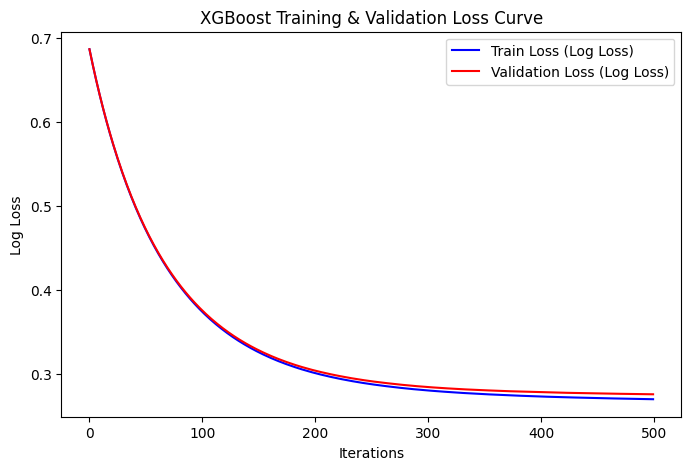

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.92    599114
           1       0.64      0.91      0.75    145192

    accuracy                           0.88    744306
   macro avg       0.81      0.89      0.84    744306
weighted avg       0.91      0.88      0.89    744306



In [56]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [57]:
from sklearn.metrics import confusion_matrix
# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 행: 실제값 (y_test), 열: 예측값 (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("✅ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

✅ Confusion Matrix
[[525619  73495]
 [ 12916 132276]]

True Positives (TP): 132276
False Positives (FP): 73495
True Negatives (TN): 525619
False Negatives (FN): 12916
